In [1]:
import os,sys,email
import numpy as np
import pandas as pd
  # Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_style("whitegrid")
import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objs as go
import wordcloud
  # notebook analysis
import networkx as nx
  # NLP
from nltk.tokenize.regexp import RegexpTokenizer


## Loading and cleaning data

In [2]:
emails_df=pd.read_csv("emails.csv")
print(emails_df.shape)
emails_df.head()

(517401, 2)


file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [3]:
# A single message looks like this
print(emails_df["message"][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [4]:
## Helper functions
def get_text_from_emails(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [5]:
# Parse the eamils into a list email objects
messages=list(map(email.message_from_string,emails_df["message"]))
# Get fields from parsed email objects
# Goes through each emails and grabs info for each key
#doc["From"] grabs who get email in all emails.
headings=messages[0].keys()#extract keys such as subject,from,to etc.
for key in headings:
    emails_df[key]=[doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_emails, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)
# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()


file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                      Message-ID  \
0  <18782981.1075855378110.JavaMail.evans@thyme>   
1  <15464986.1075855378456.JavaMail.evans@thyme>   
2  <24216240.1075855687451.JavaMail.evans@thyme>   
3  <13505866.1075863688222.JavaMail.evans@thyme>   
4  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                       From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  (phillip.allen@enron.com)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  (phillip.allen@enron.com)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  (phillip.allen@enron.com)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  (phillip.allen@enron.com)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  (phillip.allen@enron.com)   

                          To    Subject Mime-Version  \
0     (tim.belden@enron.com)                     1.0   
1  (john.lavorato@enron.com)        Re:          1.0   
2   (leah.arsdall@enron.com)   Re: test          1.0   
3    (randall.gay@enron.com)                     1.0   
4     (greg.piper@enron.com)  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding           X-From  \
0  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
1  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
2  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
3  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
4  text/plain; charset=us-ascii                      7bit  Phillip K Allen   

                                                X-To X-cc X-bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>              
1  John J Lavorato <John J Lavorato/ENRON@enronXg...              
2                                   Leah Van Arsdall              
3                                      Randall L Gay              
4                                         Greg Piper              

                                            X-Folder X-Origin  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                    X-FileName  \
0  pallen (Non-Privileged).pst   
1  pallen (Non-Privileged).pst   
2                   pallen.nsf   
3                   pallen.nsf   
4                   pallen.nsf   

                                             content     user  
0                          Here is our forecast\n\n   allen-p  
1  Traveling to have a business meeting takes the...  allen-p  
2                     test successful.  way to go!!!  allen-p  
3  Randy,\n\n Can you send me a schedule of the s...  allen-p  
4                Let's shoot for Tuesday at 11:45.    allen-p

In [6]:
emails_df.shape

(517401, 19)

In [7]:
emails_df.drop("message",axis=1,inplace=True)

In [8]:
print("Shape of the dataframe:",emails_df.shape)
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col,emails_df[col].nunique())

Shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [9]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
emails_df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [10]:

emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True,utc=True)


In [11]:
emails_df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

## Exploratory analysis


## When do people send emails ..

Text(0, 0.5, 'N emails')

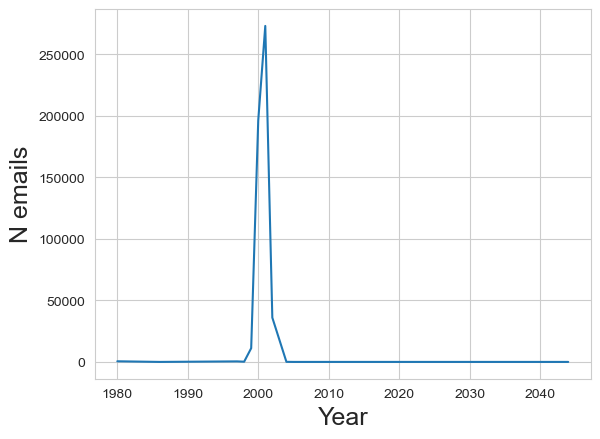

In [12]:

ax = emails_df.groupby(emails_df["Date"].dt.year)["content"].count().plot()
ax.set_xlabel("Year",fontsize=18)
ax.set_ylabel("N emails",fontsize=18)


Text(0, 0.5, 'N emails')

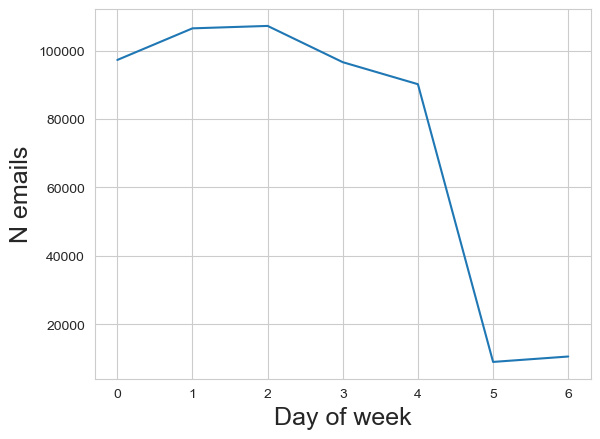

In [13]:
ax = emails_df.groupby(emails_df["Date"].dt.dayofweek)["content"].count().plot()
ax.set_xlabel("Day of week",fontsize=18)
ax.set_ylabel("N emails",fontsize=18)

Text(0, 0.5, 'N emails')

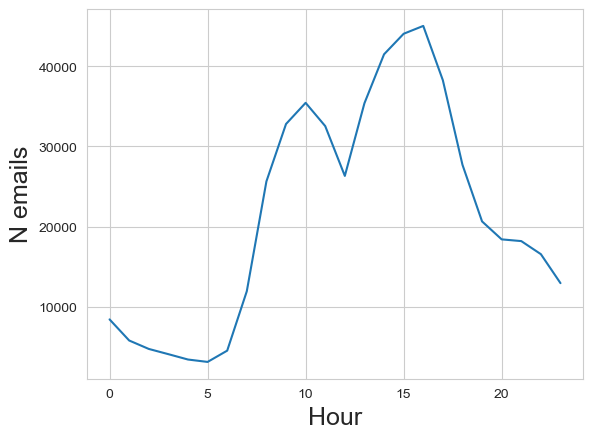

In [14]:
ax = emails_df.groupby(emails_df["Date"].dt.hour)["content"].count().plot()
ax.set_xlabel("Hour",fontsize=18)
ax.set_ylabel("N emails",fontsize=18)

## Who send most emails ..

In [15]:

# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [16]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

N emails  Subject word count  Content word count
user                                                        
kaminski-v     28465            4.217530          255.906025
dasovich-j     28234            5.237373          603.393391
kean-s         25351            4.959331          490.837561
mann-k         23381            4.211796          207.195501
jones-t        19950            4.748221          185.462607

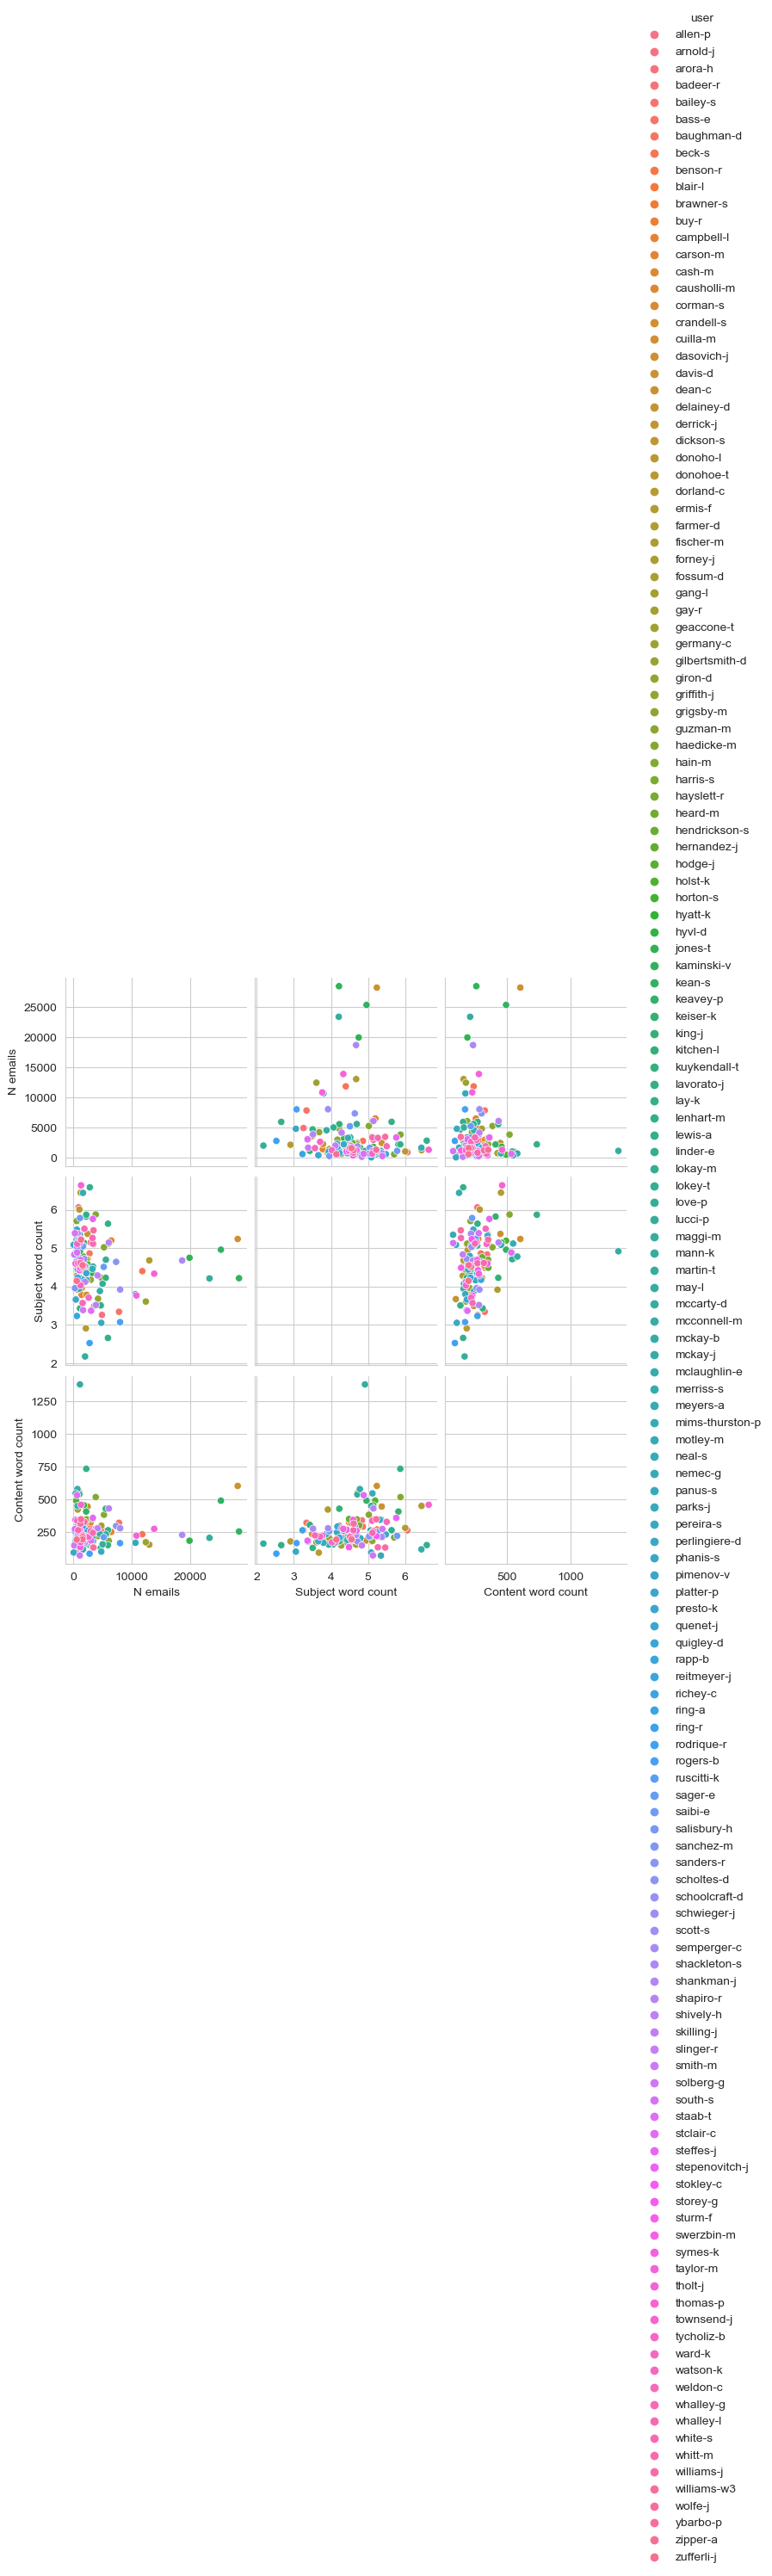

In [17]:
sns.pairplot(grouped_by_people.reset_index(), hue='user')


## Social network analysis of email senders and recipients

Let's see who sends the most emails to whom.First we'll only look at emails sent to single email address,which may be more important personal communication

In [18]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


In [19]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(5)

From                       To  count
17908           pete.davis@enron.com     pete.davis@enron.com   9141
38033       vince.kaminski@enron.com        vkaminski@aol.com   4308
28920  enron.announcements@enron.com  all.worldwide@enron.com   2206
28935  enron.announcements@enron.com    all.houston@enron.com   1701
26510             kay.mann@enron.com  suzanne.adams@enron.com   1528

Apparently some people send a lot of emails to themselves.It maybe very interesting to look at the differences between emails sent to selves and to others.

In [20]:
# Make a network of email sender and receipents
G=nx.from_pandas_edgelist(sub_df,"From","To",edge_attr="count",create_using=nx.DiGraph())
print("Number of nodes:%d,Number of edges:%d" % (G.number_of_nodes(),G.number_of_edges()))


Number of nodes:25396,Number of edges:56144


## What do the emails say ?
    
##     In the subjects:

(-0.5, 799.5, 599.5, -0.5)

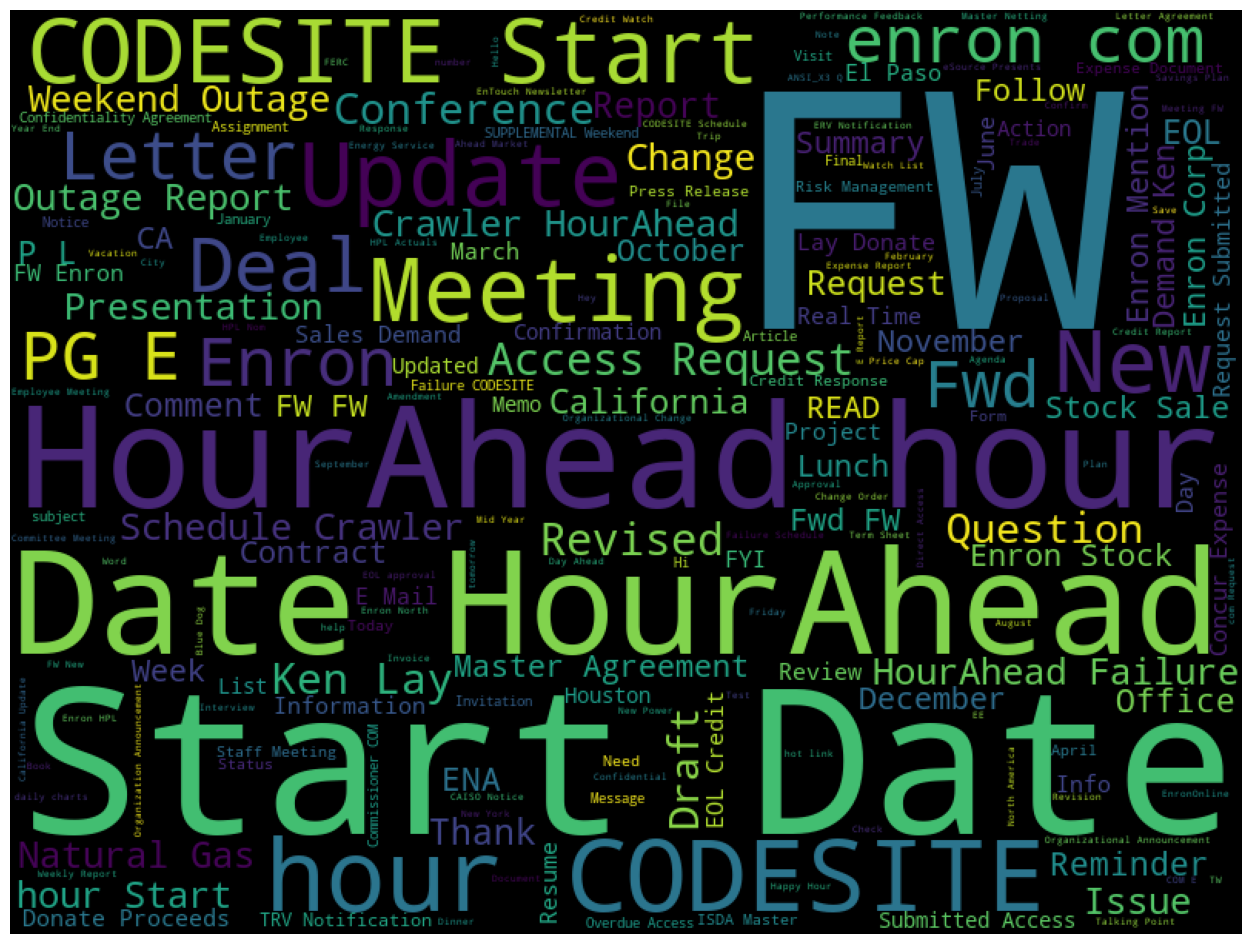

In [21]:
from sklearn.feature_extraction.text  import ENGLISH_STOP_WORDS
subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

## In the content:

(-0.5, 799.5, 599.5, -0.5)

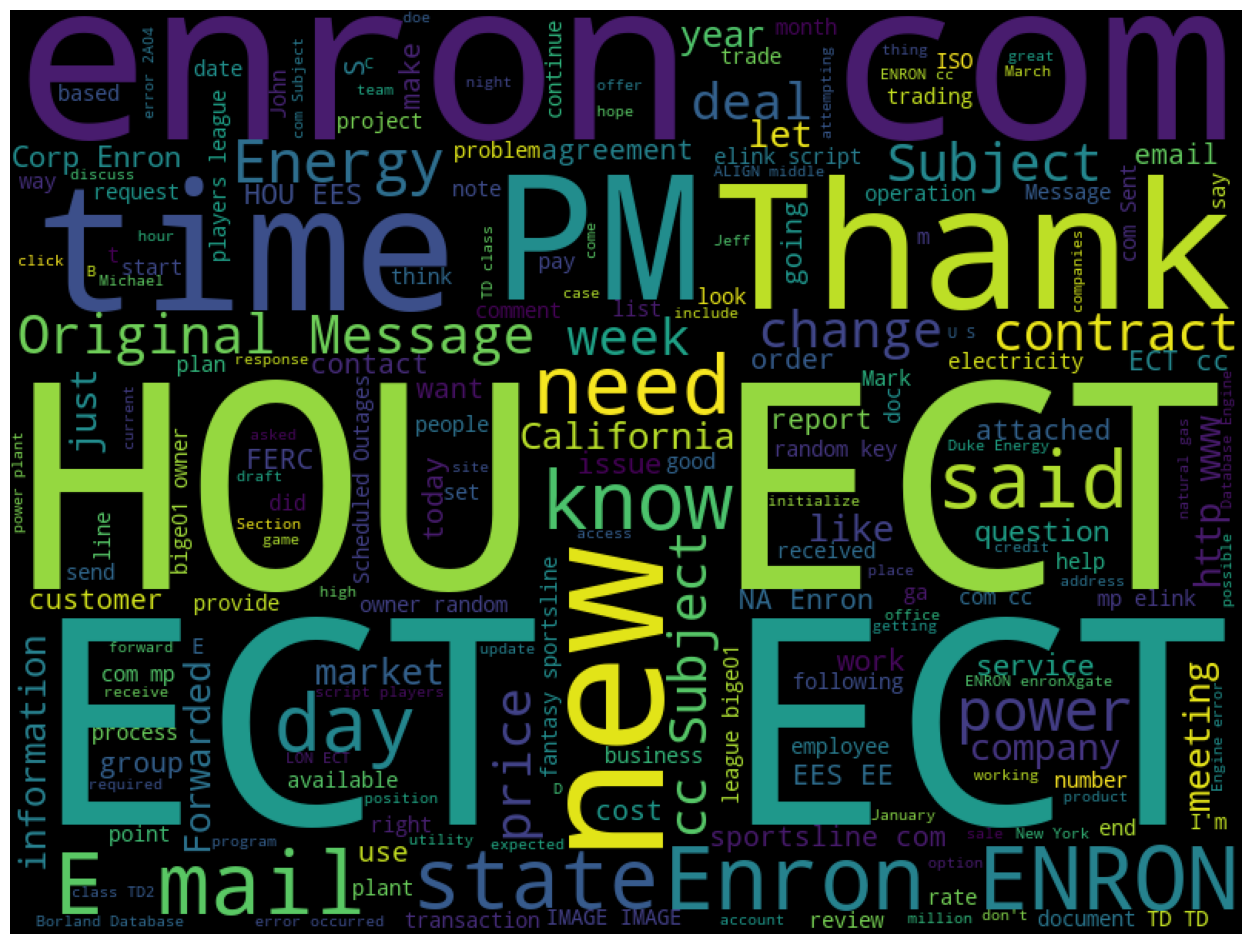

In [22]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")